In [1]:
from phylib.io.traces import get_ephys_reader
from phy.apps.template import get_template_params
from phylib.utils import Bunch
#from phy.cluster.views.trace import TraceView, select_traces
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from phy.apps.template import template_gui
template_gui("/envau/work/invibe/USERS/IBOS/openephys/Riesling/2023-03-09_10-35-09/Record Node 102/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/KSPFC/params.py")

In [2]:
def select_traces(traces, interval, sample_rate=None):
    """Load traces in an interval (in seconds)."""
    start, end = interval
    i, j = round(sample_rate * start), round(sample_rate * end)
    i, j = int(i), int(j)
    traces = traces[i:j]
    traces = traces - np.median(traces, axis=0)
    return traces

In [3]:
import copy
import logging
from pathlib import Path
logger = logging.getLogger(__name__)
from math import ceil
DEFAULT_CHUNK_DURATION = 600.0  # seconds


EPHYS_RAW_EXTENSIONS = ('.dat', '.bin', '.raw', '.mda')

In [4]:

def _find_chunks(bounds, arr):
    """Return the chunk index of each element in arr, given the chunk bounds."""
    return np.searchsorted(bounds, arr, 'right') - 1

In [5]:

def _apply_op(op, arg, arr):
    if op == 'cols':
        return arr[:, arg]
    f = getattr(arr, '__%s__' % op)
    return f(arg) if arg is not None else f()

In [6]:
# def prod(l):
#     return reduce(mul, l, 1)


def _get_subitems(bounds, item):
    """Given a list of part/chunk bounds and an item passed to __getitem__(), return
    a list (part_or_chunk_idx, subitem) to be concatenated over the first axis.
    subitem is either a slice or a list/array of indices.

    https://github.com/cortex-lab/phylib/blob/master/phylib/io/array.py
    """
    if isinstance(item, slice):
        start, stop, step = item.start, item.stop, item.step
        start = start or bounds[0]
        stop = stop or bounds[-1]
        if start < 0:
            start = start % bounds[-1]
        start = min(start, bounds[-1])
        if stop < 0:
            stop = stop % bounds[-1]
        stop = min(stop, bounds[-1])
        step = step or 1
        # NOTE: only support step == 1 for now
        assert step == 1
        assert 0 <= start <= bounds[-1]
        assert 0 <= stop <= bounds[-1]
        first_chunk, last_chunk = _find_chunks(bounds, [start, stop - 1])
        out = []
        for chunk in range(first_chunk, last_chunk + 1):
            i0, i1 = bounds[chunk:chunk + 2]
            chunk_start = max(0, start - i0)
            chunk_stop = min(i1 - i0, stop - i0)
            assert chunk_start >= 0
            assert chunk_stop <= i1
            out.append((chunk, slice(chunk_start, chunk_stop, step)))
        return out
    elif isinstance(item, (list, np.ndarray)):
        item = np.asarray(item, dtype=np.int64)
        # NOTE: only support ordered lists for now
        if len(item) >= 2:
            assert np.all(np.diff(item))
        bounds = np.asarray(bounds)
        chunks = _find_chunks(bounds, item)
        out = []
        for chunk in np.unique(chunks):
            if chunk >= len(bounds) - 1:
                raise IndexError()
            i0, i1 = bounds[chunk:chunk + 2]
            out.append((chunk, item[(i0 <= item) & (item < i1)] - i0))
        return out
    elif isinstance(item, tuple):
        return _get_subitems(bounds, item[0])
    elif isinstance(item, (int, np.generic)):
        item = int(item)
        if item < 0:
            item = item % bounds[-1]
        chunk = _find_chunks(bounds, [item])[0]
        if chunk >= len(bounds) - 1:
            raise IndexError()
        return [(chunk, item - bounds[chunk])]


def _item_length(bounds, item):  # pragma: no cover
    """Return the size of the __getitem__() output as a function of its input."""
    total = bounds[-1] - bounds[0]
    if isinstance(item, slice):
        start = item.start or bounds[0]
        stop = item.stop or total
        if stop < 0:
            stop += total
        if stop > total:
            stop = total
        step = item.step or 1
        return ceil((stop - start) / float(step))
    elif isinstance(item, (list, np.ndarray)):
        return len(item)
    elif isinstance(item, tuple):
        return _item_length(bounds, item[0])
    elif isinstance(item, (int, np.generic)):
        return 1


In [7]:
class BaseEphysReader(object):
    # To be set in child classes:
    sample_rate = 0
    n_channels = 0
    chunk_bounds = ()  # [0, ..., n_samples]
    part_bounds = ()  # [0, ..., part_size_0, ..., part_size_n]
    dtype = None
    name = 'default'
    dir_path = None

    ndim = 2
    sample_onset = 0
    sample_offset = None

    def __init__(self):
        self._ops = []

    @property
    def n_chunks(self):
        return max(0, len(self.chunk_bounds) - 1)

    @property
    def n_samples(self):
        # TODO: take subset interval into account
        return self.chunk_bounds[-1]

    @property
    def n_parts(self):
        return max(0, len(self.part_bounds) - 1)

    @property
    def shape(self):
        return (self.n_samples, self.n_channels)

    @property
    def duration(self):
        return self.n_samples / float(self.sample_rate)

    def _get_part(self, part_idx, subitem):
        """Return the requested item[] of a part of the data. To be overriden."""
        raise NotImplementedError()

    def __getitem__(self, item):
        if isinstance(item, tuple):
            if len(item) == 1:  # pragma: no cover
                item = item[0]
            elif len(item) == 2:
                # Lazy indexing on the second axis, e.g. for channel mapping.
                cols = item[1]
                # NOTE the self = here.
                self = self._append_op('cols', cols)
                if item[0] == slice(None, None, None):
                    # traces[:, cols] should return a cloned EphysReader instance.
                    return self
                item = item[0]
            else:
                raise NotImplementedError()
        # TODO: take interval into account
        # item = _subset_interval(interval, item)
        to_concat = []
        # Obtain the requested parts.
        for part_idx, subitem in _get_subitems(self.part_bounds, item):
            to_concat.append(self._get_part(part_idx, subitem))
        # Concatenate the parts.
        out = np.vstack(to_concat)
        return self._apply_ops(out)

    def _append_op(self, op, arg=None):
        clone = copy.copy(self)
        # NOTE: make sure the clone instance has its own ops list so as to avoid side effects.
        clone._ops = list(self._ops)
        clone._ops.append((op, arg))
        return clone

    def _apply_ops(self, arr):
        for op, arg in self._ops:
            arr = _apply_op(op, arg, arr)
        return arr

    def __add__(self, arg):
        return self._append_op('add', arg)

    def __radd__(self, arg):
        return self._append_op('radd', arg)

    def __sub__(self, arg):
        return self._append_op('sub', arg)

    def __rsub__(self, arg):
        return self._append_op('rsub', arg)

    def __mul__(self, arg):
        return self._append_op('mul', arg)

    def __rmul__(self, arg):
        return self._append_op('rmul', arg)

    def __div__(self, arg):  # pragma: no cover
        return self._append_op('div', arg)

    def __rdiv__(self, arg):  # pragma: no cover
        return self._append_op('rdiv', arg)

    def __floordiv__(self, arg):
        return self._append_op('floordiv', arg)

    def __truediv__(self, arg):
        return self._append_op('truediv', arg)

    def __rfloordiv__(self, arg):
        return self._append_op('rfloordiv', arg)

    def __rtruediv__(self, arg):
        return self._append_op('rtruediv', arg)

    def __pos__(self):
        return self._append_op('pos')

    def __neg__(self):
        return self._append_op('neg')

    def __pow__(self, arg):
        return self._append_op('pow', arg)

    def __rpow__(self, arg):
        return self._append_op('rpow', arg)

    def subset_time_range(self, interval):
        raise NotImplementedError()

    def iter_chunks(self, cache=True):
        for i0, i1 in zip(self.chunk_bounds[:-1], self.chunk_bounds[1:]):
            yield i0, i1

In [8]:
def _get_part_bounds(arrs):
    """Return the part bounds for multiple NumPy-like arrays."""
    return [0] + list(np.cumsum([arr.shape[0] for arr in arrs]))


def _get_chunk_bounds(arr_sizes, chunk_size):
    """Get regular chunks from multiple concatenated NumPy-like arrays."""
    assert chunk_size > 0
    b = []
    n = 0
    for arr_size in arr_sizes:
        ch = list(range(n, n + arr_size + 1, chunk_size))
        if b and ch and ch[0] == b[-1]:
            ch = ch[1:]
        b.extend(ch)
        if b[-1] != n + arr_size:
            b.append(n + arr_size)
        n += arr_size
    return b


In [9]:
def _memmap_flat(path, dtype=None, n_channels=None, offset=0, mode='r+'):
    path = Path(path)
    # Find the number of samples.
    assert n_channels > 0
    fsize = path.stat().st_size
    item_size = np.dtype(dtype).itemsize
    if (fsize - offset) % (item_size * n_channels) != 0:
        logger.warning('Inconsistent number of channels between the '
                       'params file and the binary dat file')
    n_samples = (fsize - offset) // (item_size * n_channels)
    shape = (n_samples, n_channels)
    return np.memmap(path, dtype=dtype, offset=offset, shape=shape, mode=mode)

In [10]:
class FlatEphysReader(BaseEphysReader):
    def __init__(self, paths, sample_rate=None, dtype=None, offset=0, n_channels=None, mode='r',
                 **kwargs):
        super(FlatEphysReader, self).__init__()
        if isinstance(paths, (str, Path)):
            paths = [paths]
        self._paths = [Path(p) for p in paths]
        assert all(p.exists() for p in self._paths)
        self.name = paths[0].stem
        self.dir_path = paths[0].parent
        self._mmaps = [
            _memmap_flat(path, dtype=dtype, n_channels=n_channels, offset=offset, mode=mode)
            for path in paths]

        self.sample_rate = sample_rate
        self.dtype = dtype
        self.n_channels = n_channels
        chunk_size = int(round(DEFAULT_CHUNK_DURATION * sample_rate))
        self.part_bounds = _get_part_bounds(self._mmaps)
        self.chunk_bounds = _get_chunk_bounds(
            [arr.shape[0] for arr in self._mmaps], chunk_size=chunk_size)

        assert self.sample_rate > 0
        assert self.n_channels >= 0

In [11]:
def _get_ephys_constructor(obj, **kwargs):
    """Return the class, argument, and kwargs to create an Ephys instance from any
    compatible Python object."""
    if 'n_channels_dat' in kwargs:  # pragma: no cover
        kwargs['n_channels'] = kwargs.pop('n_channels_dat')
    if isinstance(obj, (str, Path)):
        path = Path(obj)
        if not path.exists():  # pragma: no cover
            logger.warning("File %s does not exist.", path)
            return None, None, {}
        assert path.exists()
        ext = path.suffix
        assert ext, "No extension found in file `%s`" % path
        # Mtscomp file
        
        if ext in EPHYS_RAW_EXTENSIONS:
            return (FlatEphysReader, path, kwargs)
        elif ext == '.npy':
            return 1# (NpyEphysReader, obj, kwargs)
            
        else:  # pragma: no cover
            raise IOError("Unknown file extension: `%s`." % ext)
    

In [12]:
# def get_ephys_reader(obj, **kwargs):
#     """Get an EphysReader instance from any NumPy-like object of file path.

#     Return None if data file(s) not available.

#     """
#     klass, arg, kwargs = _get_ephys_constructor(obj, **kwargs)
#     if not klass:
#         return
#     return klass(arg, **kwargs)

In [13]:
def create_trace_gui(obj,interval, **kwargs):
    """Create the Trace GUI.
    Parameters
    ----------
    obj : str or Path
        Path to the raw data file.
    sample_rate : float
        The data sampling rate, in Hz.
    n_channels_dat : int
        The number of columns in the raw data file.
    dtype : str
        The NumPy data type of the raw binary file.
    offset : int
        The header offset in bytes.
    """

    # gui_name = 'TraceGUI'

    # # Support passing a params.py file.
    # if str(obj).endswith('.py'):
    #     params = get_template_params(str(obj))
    #     return create_trace_gui(next(iter(params.pop('dat_path'))), **params)

    kwargs = {
        k: v for k, v in kwargs.items()
        if k in ('sample_rate', 'n_channels_dat', 'dtype', 'offset')}
    traces = get_ephys_reader(obj, **kwargs)


    data=select_traces(
                traces, interval, sample_rate=traces.sample_rate)

    
    return  data

In [14]:
continuous_path = '/envau/work/invibe/USERS/IBOS/openephys/Riesling/2023-02-27_10-50-03/Record Node 102/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.dat'

In [15]:
args={'sample_rate':30000,'n_channels_dat':163,'dtype':"int16"}
interval = (0,1)

In [16]:
pp=create_trace_gui(continuous_path,interval, **args)

In [17]:
pp.shape

(30000, 163)

In [18]:
from scipy import signal,fft

In [19]:
def filter_continuous(x):
    """Basic filtering of the continuous LFP before cutting it into epochs.
    The signal is expected to be already low-pass filtered at 250Hz
    """
    fs_lfp = 30000  # sampling frequency of the signal in Hz
    fc_hp = 250  # cut-off frequency of the high pass filter in Hz

    # perform a High pass filter - butterworth filter of order 6 at 1Hz
    sos = signal.butter(6, fc_hp, "hp", fs=fs_lfp, output="sos")
    x_hp = signal.sosfilt(sos, x)

    return x_hp

In [20]:
cont_hp=filter_continuous(pp[:,0])

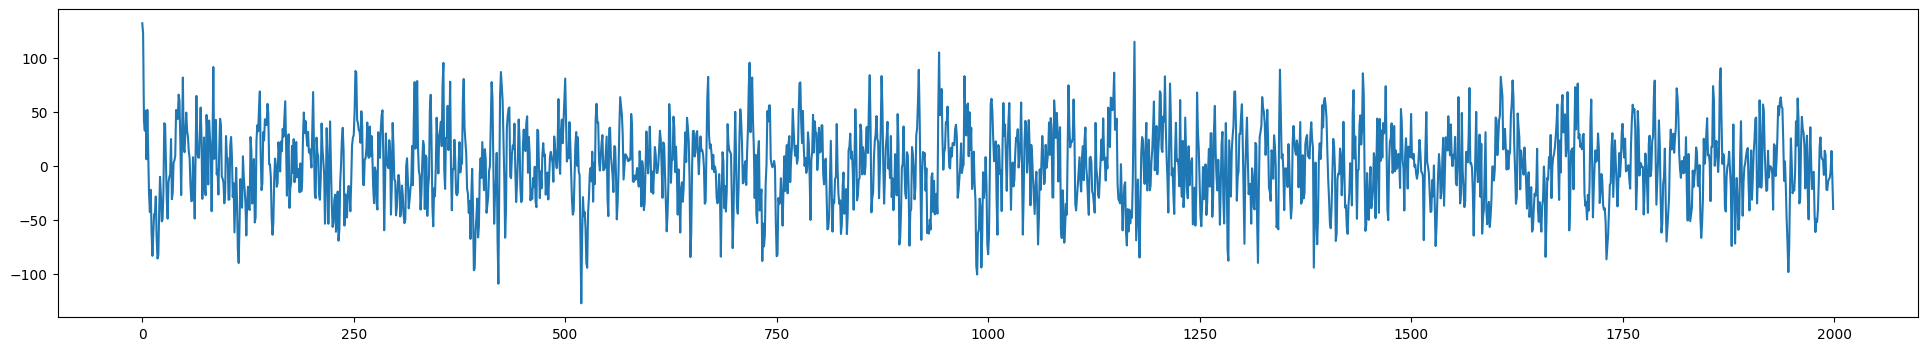

In [21]:
fig, ax = plt.subplots(figsize=(24,4))
ax.plot(cont_hp[:2000])